# Introduction

This notebook is going to cover the basics of how to use Stable Diffusion to create and modify images using existing pipelines. We'll also take a brief look at the key components within the pipeline, while leaving further exploration of them to the deep dive notebook. Specifically, we will cover:
- Generating images from text using the `StableDiffusionPipeline` and experimenting with the available arguments
- Seeing some of the key pipeline components in action
    - The VAE that makes this a 'latent diffusion model'
    - The tokenizer and text encoder that process the text prompt
    - The UNet itself
    - The scheduler, and exploring different schedulers
- Replicating the sampling loop with the pipeline components
- Editing existing images with the Img2Img pipeline
- Using inpainting and Depth2Img pipelines

❓If you have any questions, please post them on the `#diffusion-models-class` channel on the Hugging Face Discord server. If you haven't signed up yet, you can do so here: https://huggingface.co/join/discord


# Setup

In [4]:
%pip install -Uq diffusers ftfy accelerate

In [5]:
# Installing transformers from source for now since we need the latest version for Depth2Img
%pip install -Uq git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
    )

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

In [8]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Generating Images from Text

Let's load a Stable Diffusion pipeline and see what it can do. There are multiple different versions of Stable Diffusion, with the latest at the time of writing being version 2.1. If you'd like to explore an older version, simply replace the model ID with the appropriate model (for example, you could try "CompVis/stable-diffusion-v1-4" or pick a model from the [dreambooth concepts library](https://huggingface.co/sd-dreambooth-library)).

In [9]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

If you're running out of GPU memory, there are some things you can do to reduce the RAM usage:
- Load the FP16 version (not supported on all systems). With this you may also need to convert tensors to torch.float16 when experimenting with individual components of the pipeline:

  `pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)`

- Enable attention slicing. This reduces GPU memory usage at the cost of a small reduction in speed:

 `pipe.enable_attention_slicing()`
- Reduce the size of the images you're generating

Once the pipeline is loaded, we can generate an image based on a prompt with the following code:

In [8]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/1f758383196d38df1dfe523ddb1030f2bfab7741/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/1f758383196d38df1dfe523ddb1030f2bfab7741/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/1f758383196d38df1dfe523ddb1030f2bfab7741/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/1f758383196d38df1dfe523ddb1030f2bfab7741/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Pipelines loaded with `dtype=torch.float16` cannot run with `c

In [9]:
pipe.enable_attention_slicing()


In [11]:
# Sabit bir rastgelelik sağlayıcı (generator) tanımlanıyor
# Böylece her çalıştırmada aynı görüntü üretilir (tekrarlanabilirlik sağlanır)
#generator = torch.Generator(device=device).manual_seed(42)

# Stable Diffusion pipeline çalıştırılıyor
# Görsel üretimiyle ilgili çeşitli ayarlar bu fonksiyona parametre olarak veriliyor
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",      # Üretilmek istenen sahnenin tanımı
    negative_prompt="Oversaturated, blurry, low quality",        # Görselde olmaması istenen özellikler
    height=480, width=640,                                       # Görüntü boyutu (yükseklik x genişlik)
    guidance_scale=8,                                            # Prompt'a ne kadar sadık kalınacağı (7–10 arası önerilir)
    num_inference_steps=20,                                      # Görsel üretimi sırasında kaç adım yapılacağı
    #generator=generator                                          # Sabit rastgelelik üreteci (aynı sonucu almak için)
)

# Üretilen görseli görüntüleme (ilk ve genellikle tek görüntü)
pipe_output.images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Exercise:** Spend some time playing with the cell above, using your own prompts and tweaking settings to see how they affect the output. Use a different random seed or remove the `generator` argument to get different results each time.

Key arguments to tweak:
- Width and height specify the size of the generated image. They must be divisible by **8** for the VAE to work (which we'll see in a future section).
- The number of steps influences the generation quality. The default (50) works well, but in some cases you can get away with as few as 20 steps which is handy for experimentation.
- The negative prompt is used during the classifier-free guidance process, and can be a useful way to add additional control. You can leave it out, but many users find it useful to list some undesirable descriptions in the negative prompt as shown above.
- The `guidance_scale` argument determines how strong the classifier-free guidance (CFG) is. Higher scales push the generated images to better match the prompt, but if the scale is too high the results can become over-saturated and unpleasant.

If you're looking for prompt inspiration, the [Stable Diffusion Prompt Book](https://stability.ai/sdv2-prompt-book) is a good place to start.

You can see the effect of increasing the guidance scale in the following cell:

  0%|          | 0/35 [00:00<?, ?it/s]

KeyboardInterrupt: 

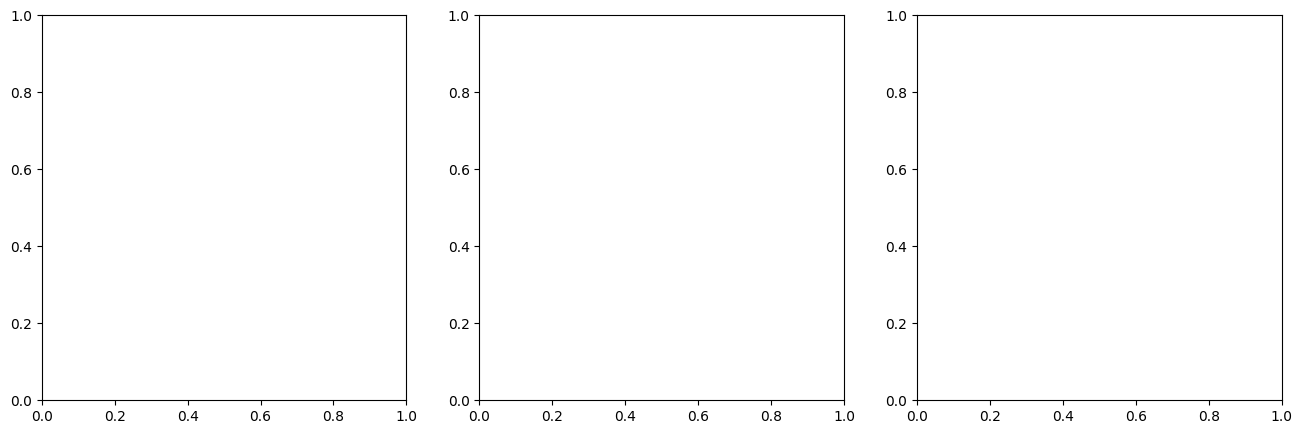

In [12]:
#@markdown comparing guidance scales:
cfg_scales = [1.1, 8, 12] #@param
prompt = "A collie with a pink hat" #@param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

Tweak the values above to try different scales and prompts. Interpretation is subjective of course, but to my eye anything in the 8-12 range produces better results than values below or above this range.

# Pipeline Components

The `StableDiffusionPipeline` we're using is a little more complex than the `DDPMPipeline` we've explored in the previous units. In addition to the UNet and the scheduler, there are a number of other components included in the pipeline:

In [13]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


To better understand how the pipeline works, let's briefly see each component in action individually and then put them all together to replicate the functionality of the pipeline for ourselves.

### The VAE

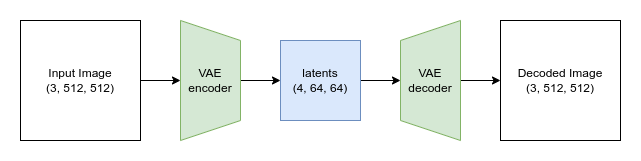

The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this 'latent' representation back into something close to the original input. When generating images with Stable Diffusion, we first **generate the latents** by applying the diffusion process in the 'latent space' of the VAE, and then **decode them at the end** to view the resulting image.

Here is some code that takes an input image, encodes it to a latent representation and then decodes it again using the VAE:

In [ ]:
# Rastgele bir sahte veri (görüntü) oluşturuyoruz.
# Boyutları: (1, 3, 512, 512) — 1 adet görüntü, 3 renk kanalı (RGB), 512x512 piksel.
# Değerler rastgele [0,1) arasında üretiliyor, sonra *2-1 ile [-1,1) aralığına çekiliyor.
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape:", images.shape)  # Görüntü boyutunu yazdırır

# VAE ile görüntüyü latent (sıkıştırılmış) temsile çeviriyoruz.
# torch.no_grad() ile bu işlem sırasında gradyan hesaplamıyoruz (hafıza ve hız için).
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)  # Latent temsilin boyutunu yazdırır

# Latent temsili tekrar orijinal görüntü alanına decode ediyoruz.
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)  # Decode edilmiş görüntünün boyutunu yazdırır


Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


Gördüğünüz gibi, 512x512 boyutundaki görüntü, 64x64 boyutunda ve 4 kanallı bir latent temsile sıkıştırılıyor.
Her mekansal boyutta yaklaşık 8 kat küçülme olmasının sebebi, belirtilen genişlik ve yüksekliğin 8’in katları olması gerektiğidir.

Bu bilgi açısından zengin 4x64x64 boyutundaki latent temsillerle çalışmak, büyük 512 piksel boyutundaki görüntülerle çalışmaktan daha verimlidir.
Bu sayede difüzyon modelleri daha hızlı çalışır, daha az kaynak kullanır ve daha hızlı eğitilir.

VAE’nin decode (geri çevirme) süreci mükemmel olmasa da, ortaya çıkan küçük kalite kaybı genellikle göz ardı edilebilir ve sağlanan verimlilik kazanımı buna değerdir. the small quality tradeoff is generally worth it.

Not: Yukarıdaki kod örneğinde kullanılan 0.18215 ölçeklendirme faktörü, Stable Diffusion’ın eğitim sürecinde uygulanan işleme uyum sağlamak için gereklidir.

### The Tokenizer and Text Encoder


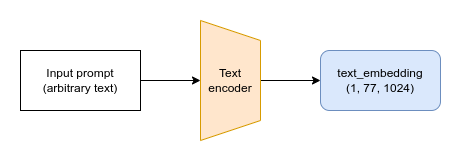


Metin kodlayıcının (text encoder) amacı, verilen bir metin girdiğini (prompt) sayısal bir temsil haline dönüştürmektir.
Bu sayısal temsil daha sonra UNet modeline koşullandırma (conditioning) olarak verilir.

İşlem şu şekilde işler:

İlk olarak metin, pipeline’ın tokenizer’ı tarafından bir dizi token’a (anlamsal parçacıklara) ayrılır.

Metin kodlayıcının yaklaşık 50.000 token’dan oluşan bir kelime hazinesi vardır; kelime hazinesinde olmayan kelimeler daha küçük alt kelimelere (sub-word) bölünür.

Bu token’lar daha sonra metin kodlayıcı modeline (transformer tabanlı bir model, CLIP’in metin kodlayıcısı olarak önceden eğitilmiş) beslenir.

Önceden eğitilmiş bu transformer modelinin, difüzyon görevinde de faydalı olacak zengin metin temsilleri öğrenmiş olması beklenir.

Şimdi bu süreci test edelim:
Önce bir örnek prompt’u manuel olarak tokenize edip metin kodlayıcıdan geçirerek,
sonra da pipeline’ın encode_prompt metodunu kullanarak (ki bu yöntem prompt’u maksimum 77 token uzunluğuna göre otomatik olarak doldurma veya kısaltma işlemlerini içerir) işlemin tamamını görelim.



In [ ]:
# Örnek bir prompt'u manuel olarak tokenize etme ve kodlama

# Tokenize işlemi: prompt'u token ID'lerine çeviriyoruz
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']

print("Token ID -> Çözümlenmiş token")
# Token ID'lerini çözümlüyor ve her birini ekrana yazdırıyoruz
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Token ID'lerini PyTorch tensörüne çevirip uygun cihaza (CPU/GPU) taşıyoruz
input_ids = torch.tensor(input_ids).to(device)

# CLIP metin kodlayıcıdan geçiriyoruz (gradyan hesaplamasını kapatıyoruz)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']

# Oluşan metin gömme (embedding) vektörünün boyutunu yazdırıyoruz
print("Text embeddings shape:", text_embeddings.shape)


Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [ ]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, True, '')
text_embeddings.shape

torch.Size([2, 77, 1024])

These text embeddings (the so-called 'hidden states' of the last transformer block in the text encoder model) will be fed to the UNet as an additional argument to the `forward` method, which we'll see in the next section.

### The UNet

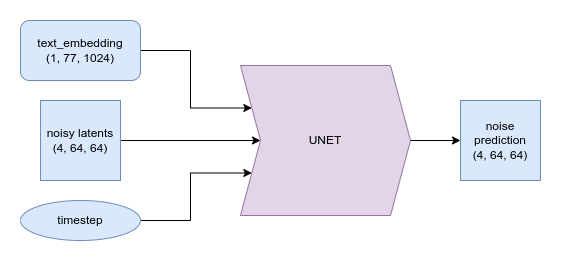

UNet, önceki bölümlerde gördüğümüz UNet’ler gibi gürültülü bir girdi alır ve bu gürültüyü tahmin etmeye çalışır.
Ancak, önceki örneklerden farklı olarak, bu modelin girdisi doğrudan bir görüntü değil, görüntünün latent (sıkıştırılmış) temsilidir.

Ayrıca, bu UNet yalnızca zaman adımı (timestep) bilgisiyle değil, aynı zamanda prompt’a ait metin embedding’leriyle de koşullandırılır. Yani, metin bilgisi doğrudan modele rehberlik eder.

Aşağıda, UNet’in sahte (dummy) veriler üzerinde nasıl tahmin yaptığını gösteren bir örnek var:


In [ ]:
# Sahte (dummy) giriş verileri oluşturuluyor

# Zaman adımı (timestep) alınıyor — difüzyon sürecinin ilk adımı
timestep = pipe.scheduler.timesteps[0]

# Latent uzayda rastgele bir girdi oluşturuluyor (1 örnek, 4 kanal, 64x64 boyut)
latents = torch.randn(1, 4, 64, 64).to(device)

# Rastgele bir metin embedding'i oluşturuluyor
# 1 örnek, 77 token uzunluğu, her token için 1024 boyutlu vektör (CLIP embedding boyutu)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# UNet modeli ile tahmin yapılıyor
with torch.no_grad():  # Gradyan hesaplamayı kapat (hafıza & hız açısından avantajlı)
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
# UNet çıktısının boyutunu yazdır
print('UNet output shape:', unet_output.shape)  # Girdiyle aynı: (1, 4, 64, 64)


UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler

Scheduler (zamanlayıcı), difüzyon sürecinde kullanılan gürültü planını (noise schedule) saklar ve modelin tahminlerine göre gürültülü örneği günceller.
Varsayılan olarak kullanılan zamanlayıcı PNDMScheduler’dır, ancak isterseniz LMSDiscreteScheduler gibi başka zamanlayıcılar da kullanabilirsiniz — tabii ki aynı yapılandırma (config) ile başlatıldıkları sürece.

Zamanla değişen gürültü seviyesini (ᾱ değerine göre) görmek için gürültü planını grafikleştirebiliriz:

(ᾱ: difüzyon sürecinde sinyalin ne kadarının kaldığını gösteren oran; zaman ilerledikçe azalır.)

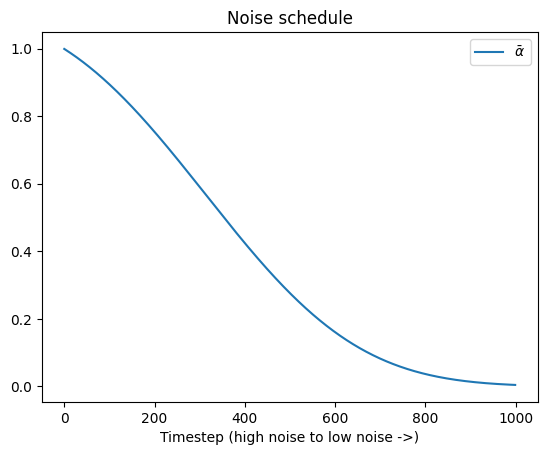

In [ ]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

If you want to try out a different scheduler, you can swap in a new one as follows:

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

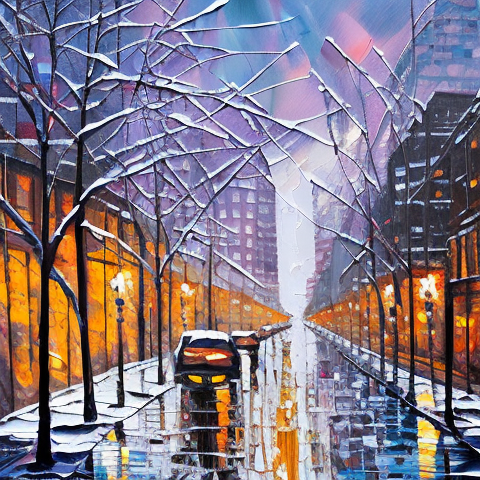

In [ ]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

You can read more on using different schedulers [here](https://huggingface.co/docs/diffusers/using-diffusers/schedulers).

### A DIY Sampling Loop

Now that we've seen all these components in action, we can put them together to replicate the functionality of the pipeline:

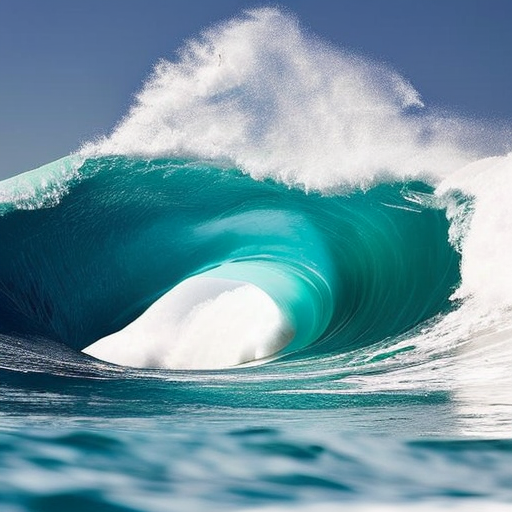

In [ ]:
# Yönlendirme (guidance) gücü — modelin prompta ne kadar uymasını istiyoruz
guidance_scale = 8  #@param

# Diffusion işlemi sırasında kaç adımda ilerleyeceğiz (ne kadar detaylı örnekleme)
num_inference_steps = 30  #@param

# İstediğimiz sahnenin açıklaması (prompt)
prompt = "Beautiful picture of a wave breaking"  #@param

# Olmasını istemediğimiz özellikler (negative prompt)
negative_prompt = "zoomed in, blurry, oversaturated, warped"  #@param

# Prompt'u modelin anlayacağı şekilde gömme vektörüne (embedding) çevir
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Başlangıç noktası olarak rastgele latent (gizli uzay) tensorü oluştur
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)

# Diffusion eğitimi sırasında kullanılan başlangıç gürültüsü seviyesiyle çarp
latents *= pipe.scheduler.init_noise_sigma

# Scheduler'a örnekleme adımlarını bildir (kaç adımda çalışacağını ayarla)
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Örnekleme adımlarında sırayla ilerle
for i, t in enumerate(pipe.scheduler.timesteps):

    # Classifier-free guidance için aynı latenti iki kere kopyala (biri conditional, biri uncond için)
    latent_model_input = torch.cat([latents] * 2)

    # Scheduler’ın istediği şekilde input ölçeklemesini yap
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # UNet modeline gürültü tahmini yaptır (metin gömmeleriyle koşullandırılmış)
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Tahmin edilen gürültüyü guidance formülü ile birleştir:
    # (prompt yok + guidance * (prompt'lu - prompt'suz))
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Bir önceki adımın latent'ini hesapla (gürültüyü çıkartıyoruz)
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Son elde edilen latent temsili gerçek bir görüntüye dönüştür
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# Görüntüyü PIL formatına çevirip göster
pipe.numpy_to_pil(image)[0]

🎯 Hazır pipeline yapıları, çoğu zaman işini kolaylaştırır çünkü tüm bileşenleri (tokenizer, encoder, UNet, scheduler, decoder vs.) zaten düzgün şekilde bağlanmış ve test edilmiştir. Yani pipe(prompt="...") şeklinde tek satırda güzel sonuçlar alabilirsin.

Ama:

🛠️ El ile yazılmış bu "örnekleme döngüsü" (sampling loop), sistemi anlamak ve gerektiğinde özelleştirmek için çok değerlidir.

Örneğin:

Kendi guidance metodunu tanımlamak,

scheduler adımlarını değiştirmek,

Farklı prompt türlerini denemek,

UNet tahminlerine müdahale etmek gibi...

Bu gibi detaylı müdahaleler için pipeline yerine bu tarz açık örnekleme döngüsü daha esnek ve öğretici olur.

# Additonal Pipelines
Peki, sadece prompt’tan görüntü üretmenin dışında neler yapabiliriz? Aslında çok şey!
Bu bölümde, Stable Diffusion’un kullanılabileceği bazı farklı ve ilginç pipeline örneklerini göstereceğiz. Böylece modelin sadece görüntü üretmekten çok daha fazlasını yapabildiğini göreceksin.

Bazı örneklerde yeni modellerin indirilmesi gerekebilir, bu yüzden eğer vaktin kısıtlıysa, modelleri indirip çalıştırmak yerine sadece burada gösterilen sonuçlara göz atabilirsin.

## Img2Img

Şimdiye kadar gördüğümüz örneklerde, görüntüleri tamamen sıfırdan ürettik; yani rastgele latentlerden başlayıp tam bir difüzyon örnekleme döngüsü uyguladık. Ancak bu şekilde başlamak zorunda değiliz.

Img2Img pipeline ise mevcut bir görüntüyü önce latent uzayına kodlar, sonra bu latentlere biraz gürültü ekler ve işleme bu gürültülü latentten başlar. Gürültü miktarı ile uygulanan gürültü giderme adımlarının sayısı, img2img işleminin güçlülüğünü (strength) belirler.

Az miktarda gürültü eklemek (düşük strength), çıktıdaki değişikliği az tutar; yani sonuç girişe çok benzer olur.

Maksimum gürültü ekleyip tam denoising yapmak ise orijinal görüntüden neredeyse tamamen farklı, yalnızca genel yapısal benzerlikler taşıyan yeni bir görüntü üretir.

Img2Img Sürecini Daha İyi Anlamak İçin
Bu pipeline’ı manuel olarak adım adım kodlayacağız. Bu sayede:

Latentlerin nasıl kodlandığını,

Gürültünün nasıl eklendiğini,

Difüzyonun nasıl uygulandığını

daha net görebileceğiz.

Ardından, Hugging Face’in diffusers kütüphanesinin img2img için kullanıma hazır StableDiffusionImg2ImgPipeline sınıfını nasıl sunduğunu da inceleyeceğiz; bu hazır pipeline hem kolaylık hem de hız açısından avantaj sağlar.

### A DIY Img2Img Loop

In [ ]:
import numpy as np

# init_image: Başlangıç olarak kullandığın gerçek (RGB) görüntü — örneğin PIL Image olabilir.

# 1. Görüntüyü PyTorch tensörüne çeviriyoruz ve normalize ediyoruz
# (H, W, C) formatındaki görüntüyü (C, H, W) formatına çeviriyoruz
init_image_tensor = torch.from_numpy(np.array(init_image).transpose(2, 0, 1)).float() / 255.0  # Piksel değerlerini [0, 255] → [0, 1]

# 2. Normalize edilmiş tensörü [-1, 1] aralığına dönüştürüyoruz (VAE eğitimi bu aralıkta yapıldı)
init_image_tensor = 2.0 * init_image_tensor - 1.0  # [0, 1] → [-1, 1]

# 3. Tensöre batch boyutu ekliyoruz (tek bir görüntü olduğu için 1)
init_image_tensor = init_image_tensor.unsqueeze(0).to(device)  # (1, C, H, W)

# 4. VAE encoder ile görüntüyü latent uzayına kodluyoruz
with torch.no_grad():
    # VAE'nin encode fonksiyonu bir dağılım döndürür, buradan örnekleme yapıyoruz
    # Daha sonra, bu latent'e ölçekleme katsayısı uyguluyoruz (modelin eğitildiği ölçek)
    init_image_latents = pipe.vae.encode(init_image_tensor).latent_dist.sample() * pipe.vae.config.scaling_factor


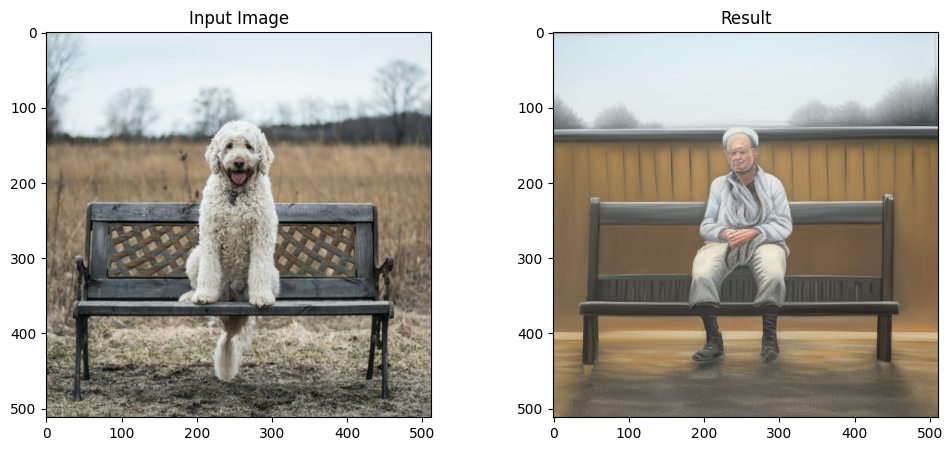

In [ ]:
guidance_scale = 7.5  # Prompt rehberliğinin ne kadar güçlü olacağını belirler (daha yüksek = daha fazla prompt etkisi)
num_inference_steps = 30  # Diffusion adım sayısı
strength = 0.6  # Giriş görüntüsüne ne kadar noise ekleneceği. 0 = orijinale sadık, 1 = sıfırdan üretim gibi davranır.
prompt = "An oil painting of a man on a bench"  # Yeni görüntünün neye benzeyeceği

# Prompt'ı encode et (pozitif prompt, negatif prompt verilmediği için boş bırakıldı)
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, '')

# Scheduler hazırlığı (kaç adımda çalışacağımızı belirtir)
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Başlangıç latenti olarak kullanılacak init_image_latents zaten yukarıda hesaplanmıştı

# --- Gürültüleme için zaman adımı hesapla (kaç adımdan itibaren başlatacağız)
# Örneğin 30 adımdan %60 = 18 adım uygularsak, ilk 12 adımı atlayacağız.
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = pipe.scheduler.timesteps[t_start:]  # Yalnızca seçilen zaman adımlarını kullan

# Gürültü eklenecek zaman adımını al
latent_timestep = timesteps[:1]  # Sadece ilk adım

# --- Latent'e gürültü ekle (başlangıç görüntüsünü boz)
# Gaussian gürültü üret
noise = torch.randn((1, 4, 64, 64), device=device,
                    generator=torch.Generator(device=device).manual_seed(42))  # reproducibility için seed

# Gürültüyü latent üzerine uygula
latents = pipe.scheduler.add_noise(init_image_latents, noise, latent_timestep)

# --- Diffusion döngüsü (gürültülü latent'ten temiz latent'e adım adım geçiş)
for i, t in enumerate(timesteps):

    # Classifier-free guidance için input'u iki kere çoğalt (biri boş prompt, biri gerçek prompt için)
    latent_model_input = torch.cat([latents] * 2)

    # Scheduler’a özel ölçekleme uygula (bazı scheduler'lar bunu gerektirir)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # UNet ile tahmini gürültüyü çıkar
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Guidance işlemi (prompt’un etkisini artır)
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Bir önceki latente geri dön (x_t → x_t-1)
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# --- Latent'leri görüntüye dönüştür
# Ölçeklendirmeyi geri al (VAE encode'da uygulanmıştı)
latents_norm = latents / pipe.vae.config.scaling_factor

# VAE decoder ile latent'i tekrar görüntüye çevir
with torch.no_grad():
    result_image = pipe.vae.decode(latents_norm).sample  # (1, 3, H, W)

# Görüntüyü [0, 1] aralığına ve sonra PIL formatına çevir
result_image = (result_image / 2 + 0.5).clamp(0, 1).squeeze()  # [-1, 1] → [0, 1]
result_image = (result_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
result_image = Image.fromarray(result_image)

# --- Sonucu göster
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image); axs[0].set_title('Input Image')
axs[1].imshow(result_image); axs[1].set_title('Result')


Now that we've manually implemented the img2img process, let’s see how to achieve the same results more efficiently using the StableDiffusionImg2ImgPipeline provided by the diffusers library.

This pipeline requires no special models, so as long as the model ID is the same as our text-to-image example above, no new files will need to be downloaded.

### Img2Img Pipeline

In [ ]:
# Loading an Img2Img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In the 'Setup' section we loaded an example `init_image` to use for this demo, but you can replace it with your own image if you'd prefer. Here's the pipeline in  action:

  0%|          | 0/30 [00:00<?, ?it/s]

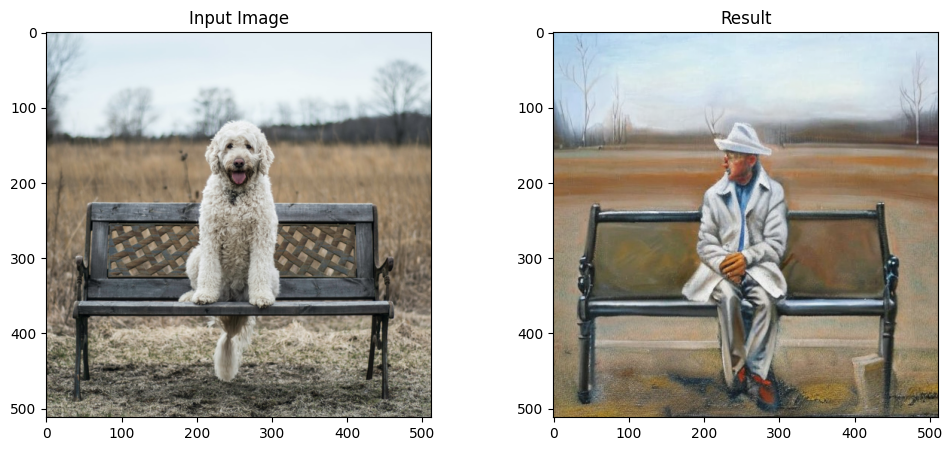

In [ ]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image=init_image, # The starting image
    strength=0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

**Exercise:** Experiment with this pipeline. Try your own images, or play with different strengths and prompts. You can use many of the same arguments as the text-to-image pipeline, so feel free to try different sizes, number of steps etc.

## In-Painting

Eğer giriş görüntüsünün bazı bölümlerini değiştirmeden korumak, diğer kısımlarını ise yeniden üretmek istersek, bu işleme “inpainting” (görsel tamamlama / boyama) denir.

Önceki örneklerde kullandığımız modelle de bu yapılabilir (örneğin StableDiffusionInpaintPipelineLegacy aracılığıyla), ancak görsel ve maske bilgilerini birlikte kullanan, özel olarak eğitilmiş modeller kullanıldığında daha iyi sonuçlar elde edilir.

Maske görüntüsü, giriş görüntüsüyle aynı boyutta olmalı. Beyaz alanlar değiştirilmek istenen bölgeleri, siyah alanlar ise korunacak bölgeleri temsil eder.

Bu süreci daha iyi anlayabilmek için, şimdi StableDiffusionInpaintPipelineLegacy'nin mantığını manuel olarak implemente edeceğiz.
Bu sayede:

Inpainting'in düşük seviyede nasıl çalıştığını öğreneceğiz,

Stable Diffusion'ın girdileri nasıl işlediğine dair içgörü kazanacağız.

Ardından bu süreci, özel olarak inpainting için eğitilmiş bir pipeline ile karşılaştıracağız.



![inpainting from_scratch](https://raw.githubusercontent.com/metamath1/diffusion-models-class/unit3/implement_img2img_inpaint/unit3/inpaint_from_scratch.png)

### A DIY Inpainting Loop

torch.Size([64, 64])

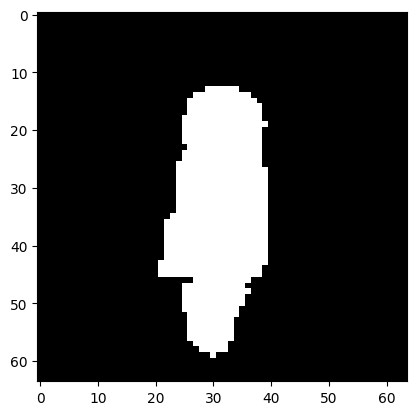

In [ ]:
# Resize mask image
mask_image_latent_size = mask_image.resize((64,64))
mask_image_latent_size = torch.tensor( (np.array(mask_image_latent_size)[...,0] > 5).astype(np.float32) )
plt.imshow(mask_image_latent_size.numpy(), cmap='gray')

mask_image_latent_size = mask_image_latent_size.to(device)
mask_image_latent_size.shape

Write the denoising loop again.

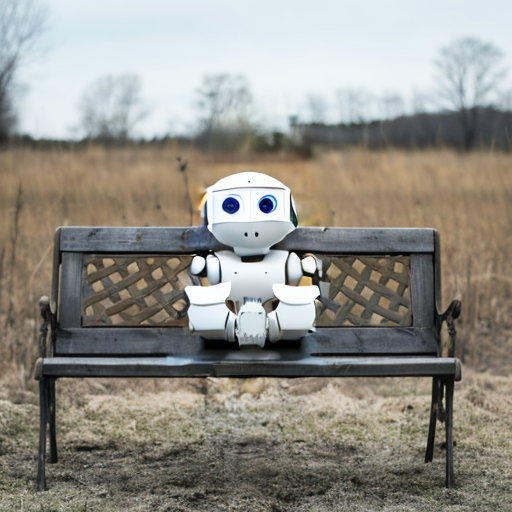

In [ ]:
guidance_scale = 8 #@param
num_inference_steps = 30 #@param
prompt = "A small robot, high resolution, sitting on a park bench"
negative_prompt = "zoomed in, blurry, oversaturated, warped"
generator = torch.Generator(device=device).manual_seed(42)

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # Perform inpainting to fill in the masked areas
    if i < len(pipe.scheduler.timesteps)-1:
        # Add noise to the original image's latent at the previous timestep t-1
        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32)
        background = pipe.scheduler.add_noise(init_image_latents, noise, torch.tensor([pipe.scheduler.timesteps[i+1]]))

        latents = latents*mask_image_latent_size # white in the areas
        background = background * (1-mask_image_latent_size) # black in the areas

        # Combine the generated and original image latents based on the mask
        latents += background

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    inpainted_image = pipe.vae.decode(latents_norm).sample

inpainted_image = (inpainted_image / 2 + 0.5).clamp(0, 1).squeeze()
inpainted_image = (inpainted_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
inpainted_image = Image.fromarray(inpainted_image)

inpainted_image

### Inpainting Pipeline

Now that we’ve manually implemented the inpainting logic, let’s see how to use a fine-tuned pipeline designed specifically for inpainting tasks. Here’s how we load such a pipeline and apply it to the example image and mask loaded in the 'Setup' section:

![inpainting from_scratch](https://raw.githubusercontent.com/huggingface/diffusion-models-class/main/unit3/inpaint_w_border.jpg)

In [ ]:
# Load the inpainting pipeline (requires a suitable inpainting model)
# pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")

# "runwayml/stable-diffusion-inpainting" is no longer available.
# Therefore, we are using the "stabilityai/stable-diffusion-2-inpainting" model instead.
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

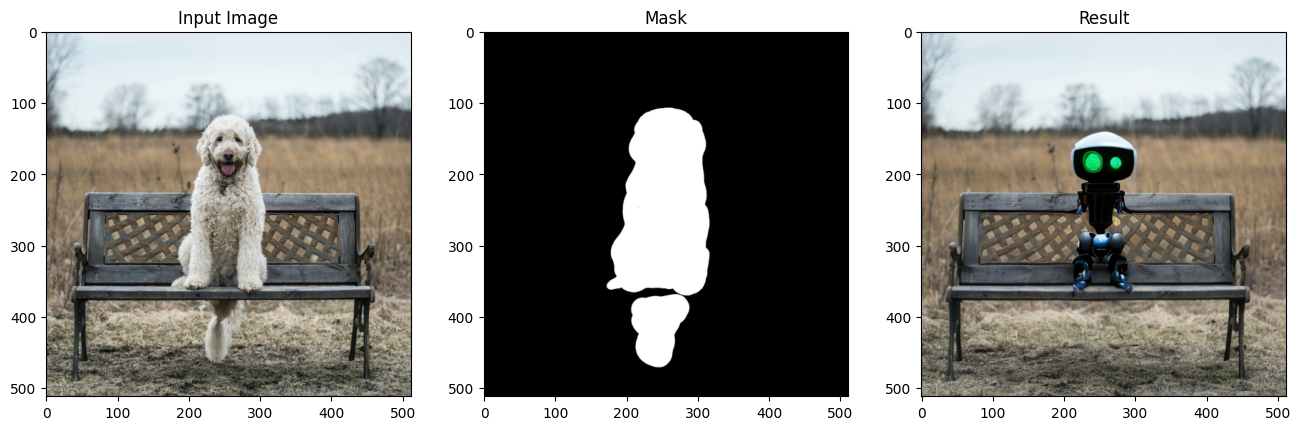

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

This can be especially powerful when combined with another model to automatically generate masks. For example, [this demo space](https://huggingface.co/spaces/nielsr/text-based-inpainting) uses a model called CLIPSeg to mask out an object to be replaced based on a text description.

### Aside: Managing Your Model Cache

Exploring different pipelines and model variants can fill up your disk space. You can see which models are currently downloaded with:

In [1]:
!ls ~/.cache/huggingface/hub/ # List the contents of the cache directory

ls: cannot access '/root/.cache/huggingface/hub/': No such file or directory


Check out [the docs on caching](https://huggingface.co/docs/huggingface_hub/main/en/how-to-cache) to see how to view and manage your cache effectively.

## Depth2Image


![depth to image examples](https://camo.githubusercontent.com/50c14634d9ff835abd36693cccbdb12fc153e56226414186012641ab75b70b6f/68747470733a2f2f68756767696e67666163652e636f2f73746162696c69747961692f737461626c652d646966667573696f6e2d322d64657074682f7265736f6c76652f6d61696e2f646570746832696d6167652e706e67)
_Input image, depth image and generated examples (image source: StabilityAI)_

ChatGPT:
Elinizdeki orijinal görüntünün kompozisyonunu koruyup, ancak renkleri veya dokuları tamamen değiştirmek istediğiniz durumlar olabilir. Img2Img yöntemi bu açıdan çok işe yarasa da, bazen düzeni koruyup renkleri değiştirmek için uygun strength (güç) değerini bulmak zor olabiliyor.

İşte burada devreye derinlik bilgisi kullanan özel olarak eğitilmiş bir model giriyor!

Bu model, görüntü oluştururken ek olarak derinlik bilgisi (depth map) alıyor.

Pipeline önce bir derinlik tahmin modeli ile giriş görüntüsünden derinlik haritası çıkarıyor.

Ardından bu derinlik haritasını, ince ayarlı UNet modeline ek koşullandırma olarak veriyor.

Böylece, orijinal görüntünün derinlik ve yapısal özelliklerini koruyarak tamamen yeni renkler ve içerik oluşturması amaçlanıyor.

Bu yöntemle, kompozisyonunuzu kaybetmeden görüntüyü farklılaştırmak mümkün oluyor.

In [ ]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

  0%|          | 0/40 [00:00<?, ?it/s]

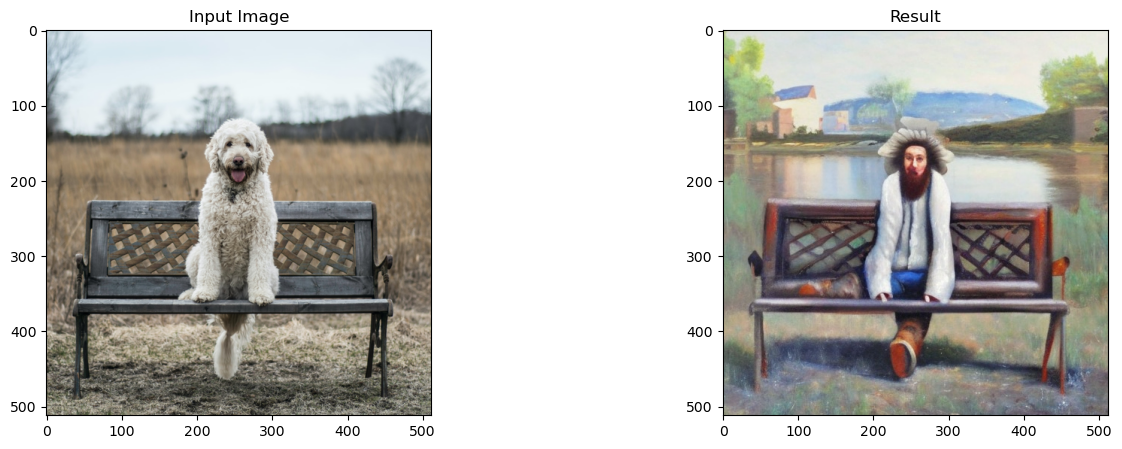

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

Note how the output compares to the img2img example - here there is much more color variation, but the overall structure is still faithful to the original. This is not ideal in this case since the man has been given some extremely weird anatomy to match the dog shape, but in some cases this is extraordinarily useful. For an example of the 'killer app' for this approach, check out [this tweet](https://twitter.com/CarsonKatri/status/1600248599254007810?s=20&t=BlzSK26sfqi2336SN0gKpQ) showing the depth model being used to texture a 3D scene!

# Where Next?

Hopefully, this has given you a taste of the many things that Stable Diffusion can do! Once you get tired of playing with the examples in this notebook, check out the **DreamBooth hackathon** notebook to see how to fine-tune your own version of Stable Diffusion which can be used with the text-to-image or img2img pipelines we've seen here.

If you're curious to dig deeper into how the different components work, then check out the **Stable Diffusion Deep Dive** notebook which goes into much more detail and shows some additional tricks we can do.

Be sure to share your creations with us and the community!